# Deep Reinforcement Learning (DQN)

Episode 0/1000 - Reward: 30.00 - Epsilon: 0.9950
Episode 100/1000 - Reward: 49.00 - Epsilon: 0.6027
Episode 200/1000 - Reward: 46.00 - Epsilon: 0.3651
Episode 300/1000 - Reward: 225.00 - Epsilon: 0.2212
Episode 400/1000 - Reward: 18.00 - Epsilon: 0.1340
Episode 500/1000 - Reward: 117.00 - Epsilon: 0.0812
Episode 600/1000 - Reward: 147.00 - Epsilon: 0.0492
Episode 700/1000 - Reward: 149.00 - Epsilon: 0.0298
Episode 800/1000 - Reward: 130.00 - Epsilon: 0.0180
Episode 900/1000 - Reward: 169.00 - Epsilon: 0.0109


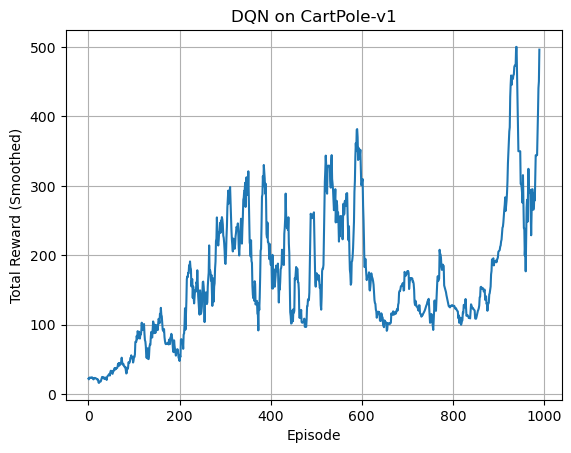

In [1]:
import random
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

# Set up the CartPole environment
env = gym.make('CartPole-v1')

# Define the neural network model to approximate Q-values
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize models
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = DQN(state_size, action_size)
target_model = DQN(state_size, action_size)
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 1000
batch_size = 64
update_target_every = 10

# Experience replay memory
memory = deque(maxlen=10000)

# Helper function for epsilon-greedy action selection
def select_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            q_values = model(state)
        return torch.argmax(q_values).item()

# Training loop
def train_dqn():
    global epsilon
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # Gym >= 0.26 returns (obs, info)
            state = state[0]
        total_reward = 0
        done = False

        while not done:
            action = select_action(state)
    
            step_result = env.step(action)
            next_state, reward, terminated, truncated = step_result[:4]
            done = bool(terminated) or bool(truncated)

            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards_batch, next_states, dones_list = zip(*batch)

                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(dones_list, dtype=torch.float32)

                q_values = model(states)
                next_q_values = target_model(next_states)

                q_values_for_actions = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                target_q_values = rewards_batch + gamma * torch.max(next_q_values, dim=1)[0] * (1 - dones)

                loss = criterion(q_values_for_actions, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if episode % update_target_every == 0:
            target_model.load_state_dict(model.state_dict())

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {epsilon:.4f}")

    # Plot rewards with moving average
    def moving_average(data, window_size=10):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.plot(moving_average(rewards))
    plt.title('DQN on CartPole-v1')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward (Smoothed)')
    plt.grid()
    plt.show()

train_dqn()


# Model Training and Evaluation Process

The **Deep Q-Network (DQN)** is a deep reinforcement learning algorithm that uses neural networks to approximate the Q-value function. It is applied to environments where traditional Q-learning would be inefficient, such as environments with large or continuous state spaces. In this section, we'll explain the model training and evaluation process for the DQN model.

---

## Steps in the Training Process:

1. **Initialization**:
    - The Q-network is initialized with random weights.
    - A replay memory buffer is initialized to store past experiences.
    - Hyperparameters such as learning rate, discount factor (gamma), exploration rate (epsilon), and batch size are set.

2. **Exploration vs. Exploitation**:
    - In each episode, the agent interacts with the environment and decides whether to explore (take a random action) or exploit (take the best action according to the Q-network).
    - **Exploration**: A random action is chosen to explore the environment.
    - **Exploitation**: The action that maximizes the Q-value for the current state is chosen.

3. **Storing Experiences**:
    - During each episode, experiences consisting of the tuple `(state, action, reward, next_state, done)` are stored in the replay buffer.
    - This helps the agent learn from diverse experiences and avoid correlated data during training.

4. **Training**:
    - After collecting enough experiences, mini-batches are sampled from the replay buffer.
    - For each mini-batch:
        - The **current Q-values** for the selected actions are computed using the Q-network.
        - The **target Q-values** are calculated using the Bellman equation:  
            `Q_target = R + gamma * max(Q(s', a'))`

            where:
            - `R` is the reward received.
            - `gamma` is the discount factor.
            - `max(Q(s', a'))` is the maximum predicted Q-value for the next state `s'`.

        - The Q-network is updated by minimizing the loss between the current Q-values and target Q-values.

5. **Target Network Update**:
    - The target Q-network (a copy of the Q-network) is updated periodically with the Q-network's weights.
    - This helps stabilize training by providing consistent targets during updates.

6. **Episode Evaluation**:
    - After each episode, the total reward is calculated and stored.
    - The agent’s performance is tracked over episodes to ensure improvement.

---

## Evaluation Metrics

1. **Total Reward**: This is the sum of the rewards received by the agent over one episode. It reflects the agent's overall performance during the episode.
    - High total rewards indicate that the agent is successfully solving the task.
    - Low total rewards indicate that the agent is not performing well and may require further tuning.

2. **Episode Length**: This is the number of steps the agent takes in an episode before reaching the terminal state.
    - Longer episodes often indicate better performance, as the agent is able to maintain control for longer periods.

3. **Convergence of Q-Values**: The Q-values should stabilize as the agent learns the optimal policy.
    - The Q-values will eventually converge when the agent has learned the best action-value function.

4. **Exploration Rate (Epsilon)**: This is the probability of selecting a random action instead of using the Q-network’s predicted best action.
    - Initially, epsilon is set high (exploration), but it gradually decays over time to encourage more exploitation as the agent learns.

---

## Final Evaluation

At the end of the training, the final Q-table or the Q-network weights can be evaluated by testing the agent’s performance in the environment without exploration (epsilon = 0). The agent should now be able to consistently choose the optimal actions and perform well in the environment.

---

## Example Results:

- After training for several episodes, the agent should show improvement by achieving higher rewards.
- You can plot the reward per episode to visualize the agent’s learning curve.

```python
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()
